In [ ]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings
# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import linear_model

import warnings 
warnings.filterwarnings('ignore')

# Universidad Nacional de Loja 
**Carrera de Ingeniería en Sistemas**

**Inteligencia Artificial**
> Autores:

*    Jorge Luis Auquilla Villamagua 
*   Roberth Fabricio Carrion Vega



---


# Proyecto de Machine Learning : Prediccion de Ventas










# **1. Datos y definición del problema**





###    **¿Cuál es el problema que quieres resolver?**

El problema que se requiere resolver es saber es saber si de puede predecir las ventas en tienda de cada familia de productos vendidos en las tiendas favoritas ubicadas en la costa oeste de Sudamérica, Ecuador.

###    **¿Por qué es importante?**

 En el caso de las tiendas de comestibles, una previsión más precisa puede reducir el desperdicio de alimentos relacionado con el exceso de existencias y mejorar la satisfacción de los clientes. Con el tiempo, podrían incluso garantizar que su tienda local tenga exactamente lo que necesita la próxima vez que compre.

# **2. Colección de datos**



###   **¿Qué datos te ayudan a resolver el problema?**

Los datos que vamos a utilizar específicamente son las variables: id, date, store_nbr, family (la cual cuenta con 33 valores unicos) , sales y promotion.

El dataset "Train" ha sido extraido de "Store Sales - Time Series Forecasting" url: https://www.kaggle.com/c/store-sales-time-series-forecasting/data?select=train.csv la cual es especialista en base de datos para fines académicos,otorgando bases de datos confiables y verificadas. 

**Descripción de Datos**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 

data = pd.read_csv('./sample_data/train.csv')
data.head(8)

id        date  store_nbr        family  sales  onpromotion
0   0  2013-01-01          1    AUTOMOTIVE    0.0            0
1   1  2013-01-01          1     BABY CARE    0.0            0
2   2  2013-01-01          1        BEAUTY    0.0            0
3   3  2013-01-01          1     BEVERAGES    0.0            0
4   4  2013-01-01          1         BOOKS    0.0            0
5   5  2013-01-01          1  BREAD/BAKERY    0.0            0
6   6  2013-01-01          1   CELEBRATION    0.0            0
7   7  2013-01-01          1      CLEANING    0.0            0

# **3. Pre procesamiento de datos**

Nuestro principal objetivo es predecir las ventas en tienda de cada familia de productos. Por esta razón, la columna de ventas debe ser examinada más seriamente. Tenemos que aprender todo, como la estacionalidad, las tendencias, las anomalías, las similitudes con otras series temporales.

In [ ]:
# Import
train = pd.read_csv('./sample_data/train.csv')
# Datetime
train["date"] = pd.to_datetime(train.date)
# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")

In [ ]:
#Contabilizar el numero de observaciones
train.count()

id             3000888
date           3000888
store_nbr      3000888
family         3000888
sales          3000888
onpromotion    3000888
dtype: int64

La mayoría de las tiendas son similares entre sí, cuando las examinamos con la matriz de correlación. Algunas tiendas, como la 20, 21, 22 y 52 pueden ser un poco diferentes.

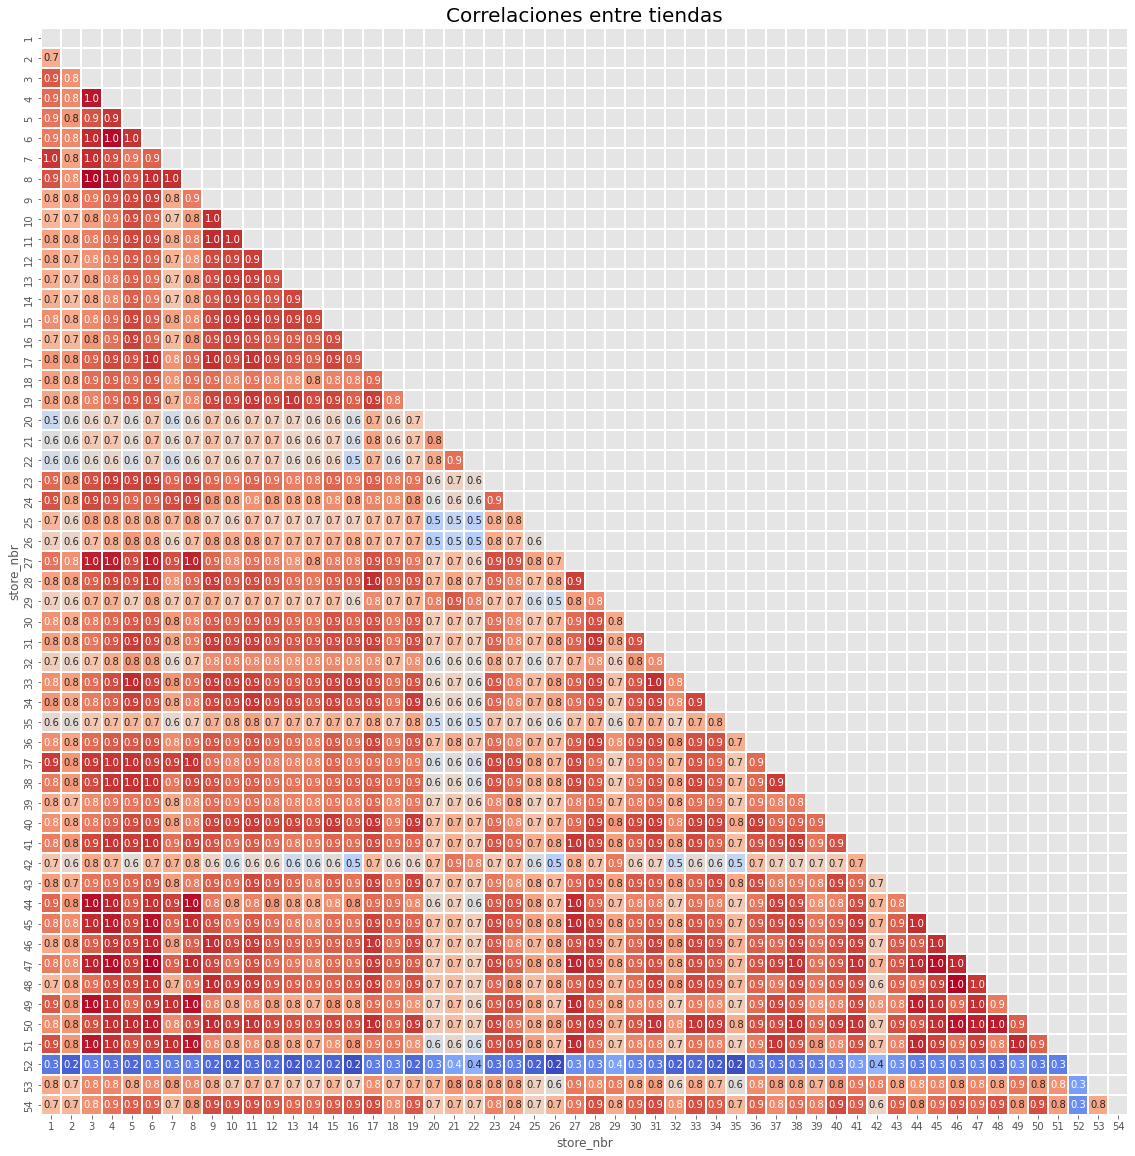

In [ ]:
a = train[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()
mask = np.triu(a.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlaciones entre tiendas",fontsize = 20)
plt.show()

A continuación hay un gráfico que nos muestra las ventas totales diarias.

In [ ]:
a = train.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Ventas diarias totales de las tiendas")

Existen algunas filas innecesarias en la serie temporal de las tiendas, algunas de ellas no tienen ventas a principios de 2013. Puedes verlas si miras las tiendas 20, 21, 22, 29, 36, 42, 52 y 53. Por lo que se decidio eliminar esas filas antes de que las tiendas abrieran. 

In [ ]:
print(train.shape)
train = train[~((train.store_nbr == 52) & (train.date < "2017-04-20"))]
train = train[~((train.store_nbr == 22) & (train.date < "2015-10-09"))]
train = train[~((train.store_nbr == 42) & (train.date < "2015-08-21"))]
train = train[~((train.store_nbr == 21) & (train.date < "2015-07-24"))]
train = train[~((train.store_nbr == 29) & (train.date < "2015-03-20"))]
train = train[~((train.store_nbr == 20) & (train.date < "2015-02-13"))]
train = train[~((train.store_nbr == 53) & (train.date < "2014-05-29"))]
train = train[~((train.store_nbr == 36) & (train.date < "2013-05-09"))]
train.shape

(3000888, 6)


(2780316, 6)

# Verificar de datos nulos

In [ ]:
#Suma de valores nulos encontrados en la columnas
data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

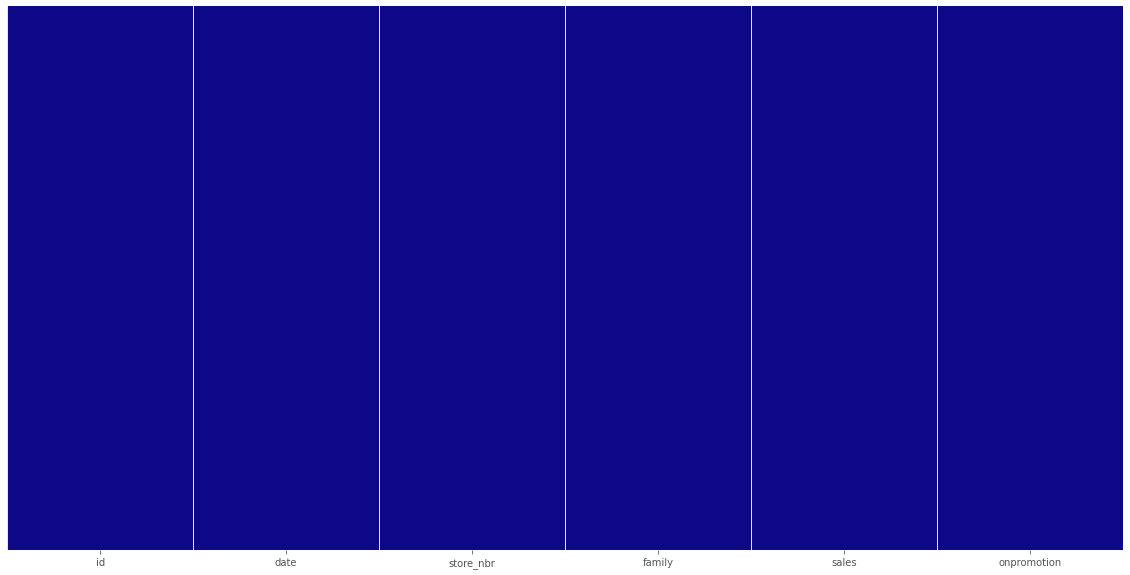

In [ ]:
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, cmap='plasma')

# Previsión cero


*   Algunas tiendas no venden algunos productos. 
*   En el siguiente código, puede ver qué productos no se venden en qué tiendas. 
*   Sera necesario eliminar los datos y crear un nuevo marco de datos para las familias de productos que nunca se venden.
*   Luego, esto para poder usarla luego en las predicciones y hacer mas facil su presentacion 

In [ ]:
# Familia de productos cuales ventas son igual a 0 (las primeras 15)
c = train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]
c.head(15)

store_nbr     family  sales
1             1  BABY CARE    0.0
397          13  BABY CARE    0.0
727          23  BABY CARE    0.0
1420         44  BABY CARE    0.0
1453         45  BABY CARE    0.0
1486         46  BABY CARE    0.0
1519         47  BABY CARE    0.0
1552         48  BABY CARE    0.0
1585         49  BABY CARE    0.0
1618         50  BABY CARE    0.0
1651         51  BABY CARE    0.0
1684         52  BABY CARE    0.0
268           9      BOOKS    0.0
301          10      BOOKS    0.0
334          11      BOOKS    0.0

# **4. Análisis de datos y modelamiento supervisado y no supervisado**

# **4.1 Análisis Exploratorio de Datos**

¿Las familias de productos son activas o pasivas?

>  pasivos si nunca se habían comprado en los últimos 60 días.




Sin embargo, algunas familias de productos dependen de la estacionalidad. Algunos de ellos pueden no estar activos en los últimos 60 días, pero eso no significa que sean pasivos.

In [ ]:
c = train.groupby(["family", "store_nbr"]).tail(60).groupby(["family", "store_nbr"]).sales.sum().reset_index()
c[c.sales == 0]

family  store_nbr  sales
54                     BABY CARE          1    0.0
55                     BABY CARE          2    0.0
63                     BABY CARE         10    0.0
65                     BABY CARE         12    0.0
66                     BABY CARE         13    0.0
...                          ...        ...    ...
1697  SCHOOL AND OFFICE SUPPLIES         24    0.0
1705  SCHOOL AND OFFICE SUPPLIES         32    0.0
1706  SCHOOL AND OFFICE SUPPLIES         33    0.0
1713  SCHOOL AND OFFICE SUPPLIES         40    0.0
1727  SCHOOL AND OFFICE SUPPLIES         54    0.0

[96 rows x 3 columns]

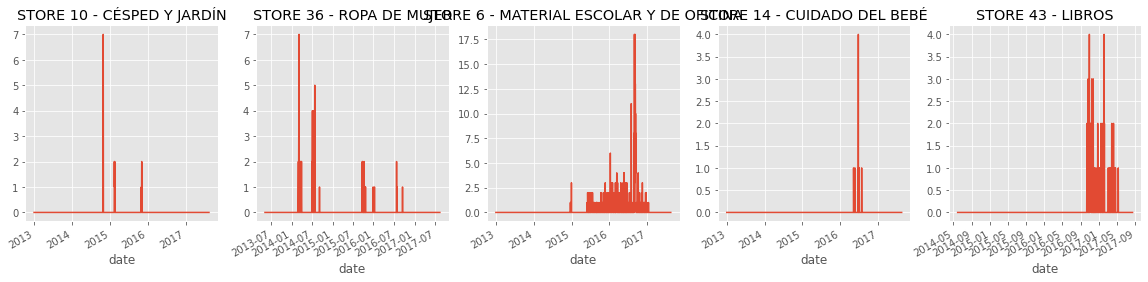

In [ ]:
fig, ax = plt.subplots(1,5, figsize = (20,4))
train[(train.store_nbr == 10) & (train.family == "LAWN AND GARDEN")].set_index("date").sales.plot(ax = ax[0], title = "STORE 10 - CÉSPED Y JARDÍN")
train[(train.store_nbr == 36) & (train.family == "LADIESWEAR")].set_index("date").sales.plot(ax = ax[1], title = "STORE 36 - ROPA DE MUJER")
train[(train.store_nbr == 6) & (train.family == "SCHOOL AND OFFICE SUPPLIES")].set_index("date").sales.plot(ax = ax[2], title = "STORE 6 - MATERIAL ESCOLAR Y DE OFICINA")
train[(train.store_nbr == 14) & (train.family == "BABY CARE")].set_index("date").sales.plot(ax = ax[3], title = "STORE 14 - CUIDADO DEL BEBÉ")
train[(train.store_nbr == 53) & (train.family == "BOOKS")].set_index("date").sales.plot(ax = ax[4], title = "STORE 43 - LIBROS")
plt.show()

In [ ]:
a = train.set_index("date").groupby("family").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "family", title = "Ventas totales diarias de la familia")

In [ ]:
a = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
px.bar(a, y = "family", x="sales", color = "family", title = "Qué familia de productos se prefiere más?")

In [ ]:
b = train.groupby("family").onpromotion.mean().sort_values(ascending = False).reset_index()
px.bar(b, y = "family", x="onpromotion", color = "family", title = "Qué familia de productos tiene mas promociones?")

# Mapa de calor para visualizar correlación
> Preferencias 



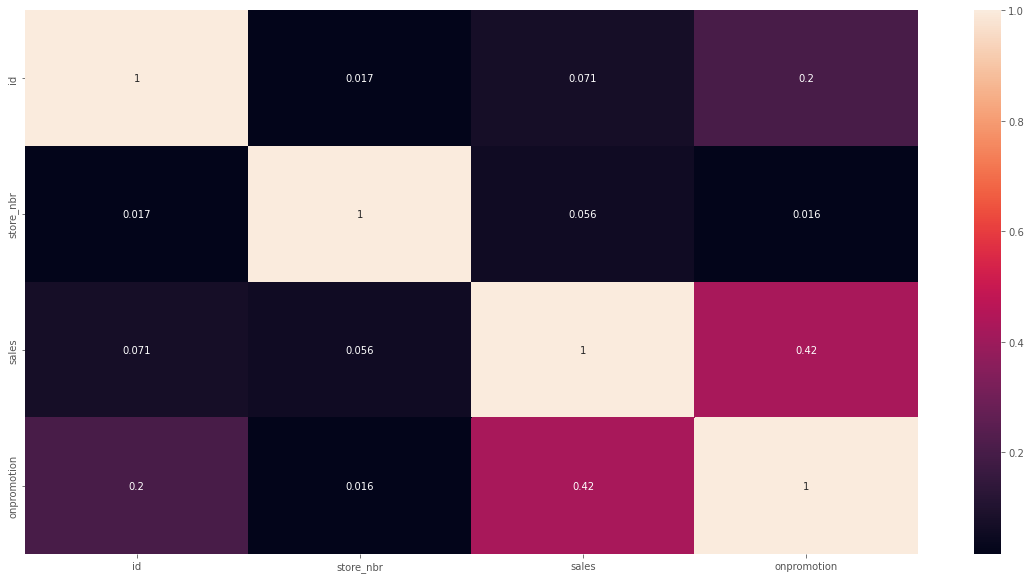

In [ ]:
sns.heatmap(train.corr(), annot=True)

## Extracion de Datos para la Prueba

In [ ]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import date
# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [ ]:
data = pd.read_csv('./sample_data/train.csv', engine='python', skipfooter=3)
data = data.groupby(data.family)

#Separacion de variables tienda - producto 
data = data.get_group("GROCERY I")
#data = data.get_group("PRODUCE")
#data = data.get_group("CLEANING")
data = data.groupby(data.store_nbr)
data = data.get_group(1)

# Proceso de fechas para un mejor uso 
data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.groupby(data['date'].dt.strftime('%Y-%m')).sum().reset_index()
data = pd.DataFrame(data, columns = ['date','sales'])
data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')
data.set_index(['date'], inplace=True)
data = data[:-1]
ass = data.iloc[-1:]
data = pd.concat([data, ass])

# **4.2 Algoritmos de aprendizaje supervisado (clasificación y regresión)**

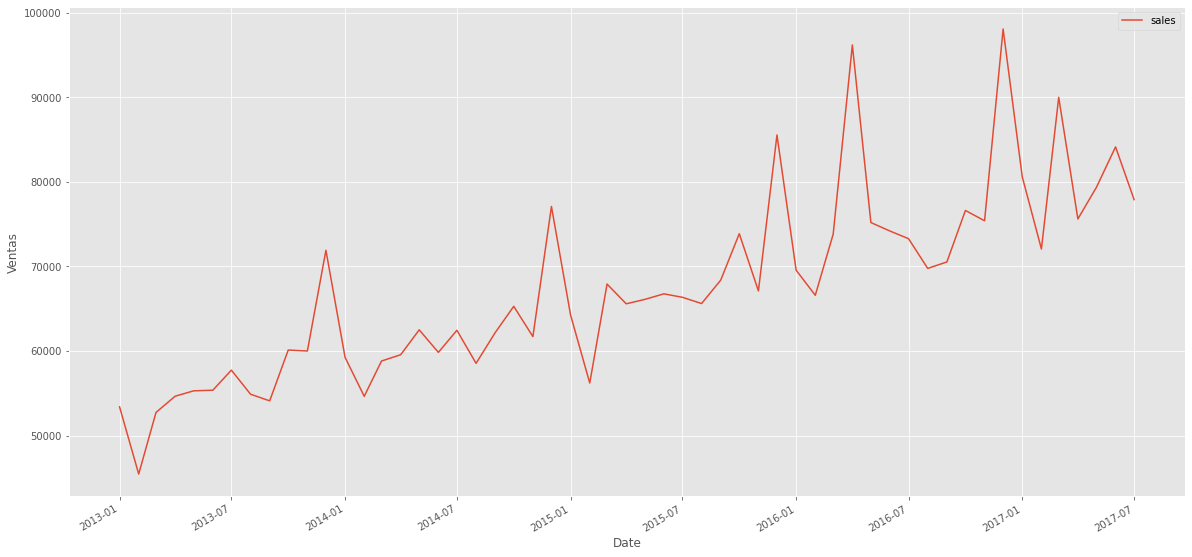

In [ ]:
# Plot the data
data.plot()
plt.ylabel('Ventas')
plt.xlabel('Date')
plt.show()

# **4.1 ARIMA** 

ARIMA significa Media Móvil Integrada Autorregresiva. Hay tres números enteros (p, d, q) que se utilizan para parametrizar los modelos ARIMA. Por ello, un modelo ARIMA no estacional se denomina ARIMA(p, d, q):

1.   p es el número de términos autorregresivos (parte AR). Permite incorporar el efecto de los valores pasados en nuestro modelo. Intuitivamente, esto sería similar a afirmar que es probable que haga calor mañana si ha hecho calor los últimos 3 días.
2.   d es el número de diferencias no estacionales necesarias para la estacionalidad. Intuitivamente, esto sería similar a afirmar que es probable que mañana haga la misma temperatura si la diferencia de temperatura en los últimos tres días ha sido muy pequeña.
3.  q es el número de errores de previsión retardados en la ecuación de predicción (parte MA). Esto nos permite establecer el error de nuestro modelo como una combinación lineal de los valores de error observados en momentos anteriores del pasado.

Cuando se trata de efectos estacionales, como en nuestro ejemplo, se utiliza ARIMA estacional, que se denota como ARIMA(p,d,q)(P,D,Q)s. Aquí, (p, d, q) son los parámetros no estacionales descritos anteriormente, (P, D, Q) siguen la misma definición pero se aplican al componente estacional de la serie temporal. El término s es la periodicidad de la serie temporal.


# **4.2 SARIMAX** 

Devuelve valores de AIC (Criterio de Información de Akaike) y BIC (Criterio de Información de Bayes) que pueden minimizarse para seleccionar el modelo que mejor se ajusta. Utilizamos el valor AIC, que estima la información que se pierde cuando se utiliza un modelo determinado para representar el proceso que genera los datos. De este modo, se aborda el compromiso entre la bondad del ajuste del modelo y la complejidad del propio modelo.



In [ ]:
# Defina los parámetros d y q para que tomen cualquier valor entre 0 y 1
q = d = range(0, 1)
# Definir los parámetros p para tomar cualquier valor entre 0 y 3
p = range(0, 3)
# Generar todas las combinaciones diferentes de tripletes p, q y q
pdq = list(itertools.product(p, d, q))
# Genere todas las combinaciones diferentes de trillizos estacionales p, q y q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Ejemplos de combinaciones de parámetros para ARIMA estacional...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Ejemplos de combinaciones de parámetros para ARIMA estacional...
SARIMAX: (1, 0, 0) x (1, 0, 0, 12)


In [ ]:
train_data = data['2013-01-01':'2016-12-01']
test_data = data['2017-01-01':'2017-02-01']

In [ ]:
warnings.filterwarnings("ignore")
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [ ]:
print('El AIC más pequeño es {} para el modelo SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

El AIC más pequeño es 455.68027902862514 para el modelo SARIMAX(2, 0, 0)x(2, 0, 0, 12)


In [ ]:
# Ajustemos este modelo
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

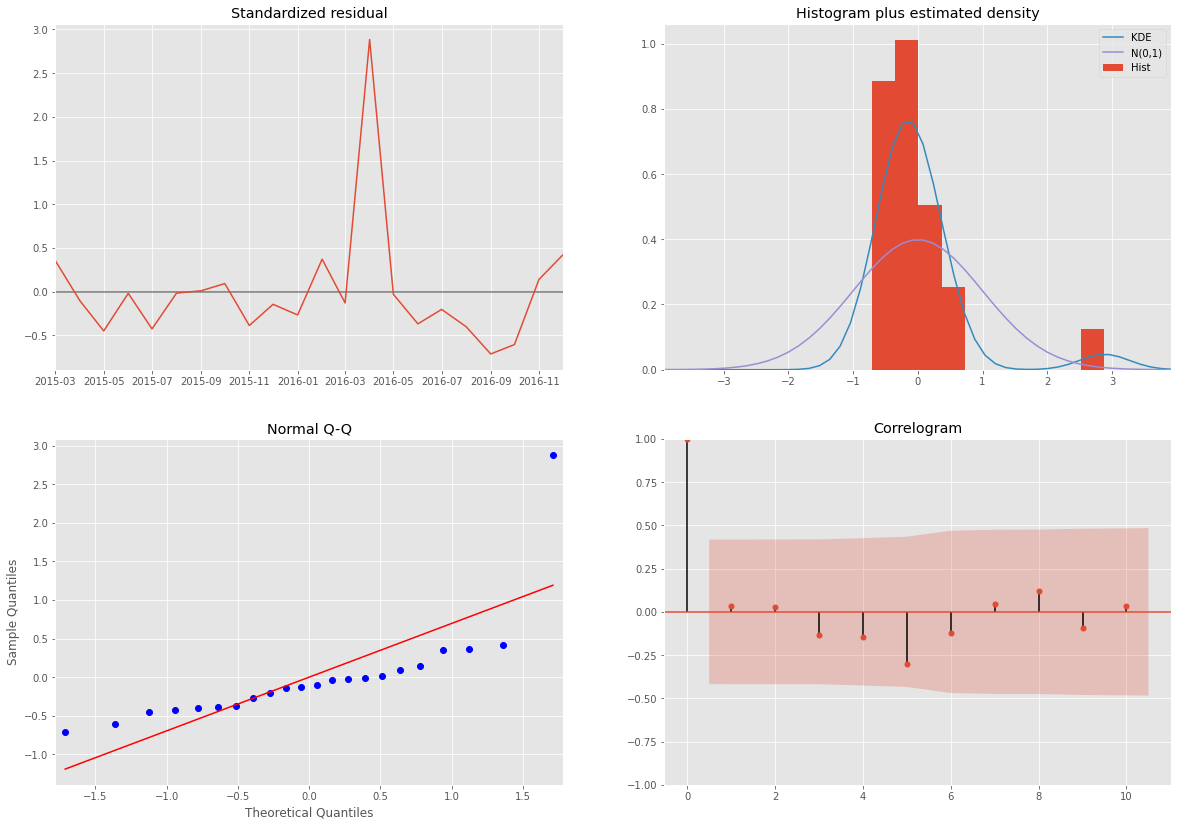

In [ ]:
#Diagnostico
results.plot_diagnostics(figsize=(20, 14))
plt.show()

# 5. Evaluación

1) Predicción por muestreo con previsión de un paso por delante del último año . En este caso, el modelo se utiliza para predecir los datos sobre los que se ha construido el modelo. La previsión de 1 paso adelante implica que cada punto previsto se utiliza para predecir el siguiente.

In [ ]:
pred0 = results.get_prediction(start='2015-01-01', dynamic=False) #un anio antes del train data 
pred0_ci = pred0.conf_int()

2) Predicción por muestreo con previsión dinámica del último año. De nuevo, el modelo se utiliza para predecir los datos sobre los que se ha construido el modelo.

In [ ]:
pred1 = results.get_prediction(start='2015-01-01', dynamic=True) #un anio antes del train data 
pred1_ci = pred1.conf_int()

3) Previsión "real" de datos fuera de muestra. En este caso se pide al modelo que prediga datos que no ha visto antes.

In [ ]:
pred2 = results.get_forecast('2018-12-01') #anios no conocidos 
pred2_ci = pred2.conf_int()

In [ ]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import linear_model
import plotly.graph_objects as go


lst1 = pred0.predicted_mean
pr1 = pd.DataFrame(lst1,columns=['sales'])
pr1.reset_index(inplace=True)
pr1 = pr1.rename(columns = {'index':'date'})

lst2 = pred1.predicted_mean
pr2 = pd.DataFrame(lst2,columns=['sales'])
pr2.reset_index(inplace=True)
pr2 = pr2.rename(columns = {'index':'date'})

lst3 = pred2.predicted_mean
pr3 = pd.DataFrame(lst3,columns=['sales'])
pr3.reset_index(inplace=True)
pr3 = pr3.rename(columns = {'index':'date'})

all_sales = pd.DataFrame(data,columns=['sales'])
all_sales.reset_index(inplace=True)
all_sales = all_sales.rename(columns = {'index':'date'})

lst4 = pred2_ci.iloc[:, 0]
pr4 = pd.DataFrame(lst4)
pr4.reset_index(inplace=True)
pr4 = pr4.rename(columns = {'index':'date','lower sales':'sales'})

lst5 = pred2_ci.iloc[:, 1]
pr5 = pd.DataFrame(lst5)
pr5.reset_index(inplace=True)
pr5 = pr5.rename(columns = {'index':'date','upper sales':'sales'})

fig = go.Figure()
plt.figure(figsize=(40, 40))
fig.add_trace(go.Scatter(x=all_sales.date, y=all_sales.sales ,name = 'Ventas Totales',))
fig.add_trace(go.Scatter(x=pr1.date, y=pr1.sales ,name = 'Predicción previsión de un paso por delante',))
fig.add_trace(go.Scatter(x=pr2.date, y=pr2.sales ,name = 'Predicción con previsión dinámica',))
fig.add_trace(go.Scatter(x=pr3.date, y=pr3.sales ,name = 'Previsión "real" de datos fuera de muestra',))
fig.add_trace(go.Scatter(x=pr4.date, y=pr4.sales,name = 'Lower Sales',fill=None,mode='lines',line_color='indigo',))
fig.add_trace(go.Scatter(x=pr5.date, y=pr5.sales,name = 'Upper Sales',fill='tonexty',mode='lines', line_color='indigo'))
fig.show()

<Figure size 2880x2880 with 0 Axes>

Para cuantificar la precisión de la predicción para Enero 2017, podemos calcular métricas como el Error Medio Absoluto, el Error Medio Cuadrático. Todas estas métricas son absolutas y, por tanto, dependen de la escala. Aunque son útiles y se utilizan ampliamente para comparar diferentes métodos en un mismo conjunto de datos, aquí sería más útil expresar el error en relación con la magnitud de la serie temporal que estamos intentando predecir. Una medida de error porcentual comúnmente utilizada es el error porcentual absoluto medio (MAPE). 


In [ ]:
prediction = pred2.predicted_mean['2017-01-01':'2017-02-01'].values
# aplanar la lista anidada
truth = list(itertools.chain.from_iterable(test_data.values))
# Error porcentual absoluto medio.
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100
print('El error porcentual absoluto medio para el pronóstico del año 2017 mes de Enero es {:.2f}%'.format(MAPE))

El error porcentual absoluto medio para el pronóstico del año 2017 mes de Enero es 2.44%
